## Introduction
- This notebook contains the experiment that evaluates the effectiveness of the PQE experiment on the RAISE-2k dataset with varying block sizes.
- The effect of varying block sizes is achieved by taking random crops on the uncompressed image before the double JPEG compression. 
- Please go through the experiment in `estimate_qtables_raise1k.ipynb` first before this experiment.
- The cropped image is then JPEG compressed twice with random quality factors in range $[50,95]$ with intervals of $5$. Then, we estimate the first quantization matrix of the doubly compressed image using our PQE implementation.
- Make sure to download the RAISE dataset before running this notebook. The dataset used in this notebook is the RAISE-2k subset.

## Imports and settings

In [1]:
import io
import os
import sys
import time
import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision.transforms.functional import to_tensor, to_pil_image
import torchjpeg.codec
from fast_histogram import histogram1d

In [2]:
sys.path.append('/home/y/yuanbo/fyp/estimate_jpeg')
sys.path.append('/home/y/yuanbo/fyp/estimate_jpeg/utils')

from utils import *
from q_table_estimation_torchjpeg import *

## Create dataset of varying block sizes and random 1st and 2nd QFs

4x4 to 64x64 blocks, so 32x32 to 512x512

In [5]:
def random_crop(im):
    w, h = im.size
    crop_size_h = np.random.randint(16, 256) // 8 * 8
    crop_size_w = np.random.randint(16, 256) // 8 * 8
    random_x = np.random.randint(0, w - crop_size_w)
    random_y = np.random.randint(0, h - crop_size_h)

    crop_area = (random_x, random_y, random_x + crop_size_w, random_y + crop_size_h)
    crop = im.crop(crop_area)
    
    return crop, (crop_size_h/8)*(crop_size_w/8)

### Make dataset

Take the random QF pairs from experiment in `estimate_qtables_raise1k.ipynb`.

In [6]:
df = pd.read_csv("random_qf_pairs.csv", header=None)
qf_pairs = list(df.itertuples(index=False, name=None))

In [9]:
test_path = glob.glob("../raise_1k/*") + glob.glob("../raise_2k/*")
print(len(test_path))

1999


In [12]:
data_folder = f'data_random_qf_vary_block'
os.makedirs(data_folder)

qf_img_block_mapping = {
    "img": [],
    "qf_1": [],
    "qf_2": [],
    "block_number": [],
}

print(f"JPEG Compression randomized quality factors. Create dataset at {data_folder}...")
start = time.time()
for i, p in enumerate(test_path):
    qf_1, qf_2 = qf_pairs[i]
    q_table_1 = scale_q_table(STANDARD_LUMI_QT, qf_1)
    q_table_2 = scale_q_table(STANDARD_LUMI_QT, qf_2)
    
    name, ext = os.path.splitext(os.path.basename(p))

    im = Image.open(p).convert('L')
    
    # take random crop of random size
    crop, bn = random_crop(im)
    qf_img_block_mapping["block_number"].append(bn)

    # first compression
    first_buffer = jpeg_compress_to_buffer(crop, q_table_1.reshape(-1))
    first_im = Image.open(first_buffer)

    # second compression
    second_buffer = jpeg_compress_to_buffer(first_im, q_table_2.reshape(-1))

    with open(f"{data_folder}/{name}.jpg", "wb") as f:
        f.write(second_buffer.getbuffer())
    
    qf_img_block_mapping["img"].append(f"{name}.jpg")
    qf_img_block_mapping["qf_1"].append(qf_1)
    qf_img_block_mapping["qf_2"].append(qf_2)

duration = time.time() - start
print(f"Time taken to create dataset of {len(test_path)} images: {round(duration, 2)} seconds.")

JPEG Compression randomized quality factors. Create dataset at data_random_qf_vary_block...
Time taken to create dataset of 1999 images: 3129.09 seconds.


r0bf7f938t.TIF is a problematic image

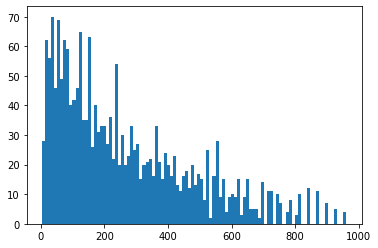

In [13]:
plt.hist(np.array(qf_img_block_mapping["block_number"]), bins=100)
plt.show()

In [14]:
qf_img_block_mapping_df = pd.DataFrame(qf_img_block_mapping)
qf_img_block_mapping_df.head()

,img,qf_1,qf_2,block_number
0,r146771d7t.jpg,60,55,81.0
1,r1e3303ebt.jpg,90,50,182.0
2,r1a2095b2t.jpg,50,60,224.0
3,r15dfc1b8t.jpg,100,55,64.0
4,r02897203t.jpg,50,100,540.0


In [15]:
qf_img_block_mapping_df.to_csv("img_qf_block_mapping.csv", index=False)

### Estimate previous quantization matrix

In [16]:
n = 100
bin_range = 100

results = {
    "img": [],
    "qf_1": [],
    "qf_2": [],
    "est_q_table": [],
    "block_number": [],
}
start = time.time()
time_taken = 0

running_first_15_acc = 0

for i in range(len(test_path)):
    p = os.path.join(data_folder, qf_img_block_mapping["img"][i])
    res = estimate_q_table(p, n, bin_range)
    time_taken = (time.time() - start)

    # calculate simple metrics
    gt_q_table = scale_q_table(STANDARD_LUMI_QT, qf_img_block_mapping["qf_1"][i])
    diff = res - gt_q_table
    first_15_dct = diff[ZIGZAG_ROW_IDX[:15], ZIGZAG_COL_IDX[:15]]
    first_15_acc = ((first_15_dct == 0).sum() / len(first_15_dct)) * 100
    running_first_15_acc += first_15_acc

    # print intermediate results
    first_15_results_str = f"F15 DCT: {round(first_15_acc, 2)}% (Acc)"
    time_str = f"{round(time_taken, 2)}/{round(time_taken/(i+1)*len(test_path), 2)}s"
    print(f"\r[{i+1}/{len(test_path)}] - [{time_str}] - [{first_15_results_str}]", end="", flush=True)

    if i != 0 and i % 100 == 0:
        running_first_15_results_str = f"First 15 DCT: {round(running_first_15_acc / (i+1), 2)}% (Acc)"
        print(f"\nCurrent dataset metrics - [{running_first_15_results_str}]")

    results["img"].append(qf_img_block_mapping["img"][i])
    results["qf_1"].append(qf_img_block_mapping["qf_1"][i])
    results["qf_2"].append(qf_img_block_mapping["qf_2"][i])
    results["est_q_table"].append(res)
    results["block_number"].append(qf_img_block_mapping["block_number"][i])


print(f"Total time taken: {round(time_taken, 2)} seconds.")
print(f"Ave time taken per image: {round(time_taken / len(test_path), 2)} seconds.")

[101/1999] - [493.9/9775.25s] - [F15 DCT: 40.0% (Acc)]]]
Current dataset metrics - [First 15 DCT: 37.82% (Acc)]
[201/1999] - [967.59/9622.95s] - [F15 DCT: 26.67% (Acc)]
Current dataset metrics - [First 15 DCT: 38.74% (Acc)]
[301/1999] - [1494.63/9926.14s] - [F15 DCT: 20.0% (Acc)]]
Current dataset metrics - [First 15 DCT: 37.94% (Acc)]
[401/1999] - [2002.75/9983.76s] - [F15 DCT: 93.33% (Acc)]]
Current dataset metrics - [First 15 DCT: 37.39% (Acc)]
[501/1999] - [2461.62/9821.93s] - [F15 DCT: 0.0% (Acc)]]]]
Current dataset metrics - [First 15 DCT: 37.68% (Acc)]
[601/1999] - [2999.9/9978.02s] - [F15 DCT: 93.33% (Acc)]]
Current dataset metrics - [First 15 DCT: 38.04% (Acc)]
[701/1999] - [3549.71/10122.49s] - [F15 DCT: 0.0% (Acc)])]
Current dataset metrics - [First 15 DCT: 38.6% (Acc)]
[801/1999] - [4084.12/10192.46s] - [F15 DCT: 0.0% (Acc)])]
Current dataset metrics - [First 15 DCT: 38.49% (Acc)]
[901/1999] - [4580.17/10161.78s] - [F15 DCT: 0.0% (Acc)]]]
Current dataset metrics - [First 15 

In [17]:
with open('res_random_qf_vary_block.pkl', 'wb') as handle:
    pickle.dump(results, handle)